In [ ]:

# Import required libraries
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
import os
import warnings
warnings.filterwarnings('ignore')

# Check available files in the working directory
print("Files in working directory:")
for file in sorted(os.listdir('.')):
    if not file.startswith('.'):
        print(f"  {file}")


Files in working directory:
  2VSM.pdb
  Surface-Plasmon-Resonance-Adaptyv-Bio-Docs.pdf
  allosteric_cdr_library.csv
  cdr_library_summary.csv
  final_top_100_candidates.csv
  known_niv_binders_full.fasta
  notebook.ipynb


In [ ]:

# Analysis Plan:
# 1. Load existing novel designs from final_top_100_candidates.csv (22 sequences)
# 2. Check for the new design files (partial_graft_designs.csv, diversified_cdr_designs.csv, novel_multi_cdr_designs.csv)
# 3. Load novelty reference databases (known_niv_binders_full.fasta, cdr_library_summary.csv, allosteric_cdr_library.csv)
# 4. Aggregate all designs and remove duplicates
# 5. Define competitive (20 residues) and allosteric (166 residues) epitopes
# 6. Implement normalized physics-based interaction score
# 7. Apply 10-AA sliding window novelty filter
# 8. Rank by normalized score and output top 100

# Step 1: Load existing novel designs
print("="*80)
print("STEP 1: Loading existing novel designs")
print("="*80)

existing_designs = pd.read_csv('final_top_100_candidates.csv')
print(f"\nLoaded {len(existing_designs)} existing designs from final_top_100_candidates.csv")
print("\nColumns:", existing_designs.columns.tolist())
print("\nFirst few rows:")
print(existing_designs.head())
print(f"\nSequence lengths range: {existing_designs['Sequence_Length'].min()} - {existing_designs['Sequence_Length'].max()}")


STEP 1: Loading existing novel designs

Loaded 22 existing designs from final_top_100_candidates.csv

Columns: ['Rank', 'Design_ID', 'Sequence', 'Design_Origin', 'Epitope_Type', 'CDR_Grafted', 'Scaffold_Used', 'Normalized_Interaction_Score', 'Raw_Interaction_Score', 'Sequence_Length', 'Original_Empirical_Score']

First few rows:
   Rank           Design_ID  \
0     1      1E5_1FNA_L4_L3   
1     2      1E5_1FNA_L3_L3   
2     3      1E5_1FNA_L3_H2   
3     4      1E5_1FNA_L3_L2   
4     5  1E5_1FNA_Nterm8_L3   

                                            Sequence   Design_Origin  \
0  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...  1E5_single_CDR   
1  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGELQGYTTPYTVPGS...  1E5_single_CDR   
2  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGEIYGSATSTVPGSK...  1E5_single_CDR   
3  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETASNLESGVPGSK...  1E5_single_CDR   
4  LQGYTTPYTTPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTV...  1E5_single_CDR   

  Epitope_Type CDR_Grafted Scaffold_Used  Normali

In [ ]:

# Step 2: Check for new design files and load them if they exist
print("\n" + "="*80)
print("STEP 2: Checking for new design files")
print("="*80)

new_design_files = [
    'partial_graft_designs.csv',
    'diversified_cdr_designs.csv', 
    'novel_multi_cdr_designs.csv'
]

all_designs_list = []
design_sources = []

# Add existing designs
for idx, row in existing_designs.iterrows():
    all_designs_list.append({
        'Sequence': row['Sequence'],
        'Design_Strategy': row['Design_Origin'],
        'Target_Epitope': row['Epitope_Type'],
        'CDR_Grafted': row.get('CDR_Grafted', 'Unknown'),
        'Scaffold_Used': row.get('Scaffold_Used', 'Unknown'),
        'Original_Normalized_Score': row.get('Normalized_Interaction_Score', np.nan),
        'Source_File': 'final_top_100_candidates.csv'
    })

print(f"\nAdded {len(existing_designs)} designs from final_top_100_candidates.csv")

# Check for and load new design files
for file in new_design_files:
    if os.path.exists(file):
        print(f"\nFound {file}!")
        df = pd.read_csv(file)
        print(f"  Loaded {len(df)} designs")
        print(f"  Columns: {df.columns.tolist()}")
        
        # Add to aggregated list
        for idx, row in df.iterrows():
            all_designs_list.append({
                'Sequence': row['Sequence'],
                'Design_Strategy': row.get('Design_Strategy', row.get('Design_Origin', 'Unknown')),
                'Target_Epitope': row.get('Target_Epitope', row.get('Epitope_Type', 'Unknown')),
                'CDR_Grafted': row.get('CDR_Grafted', row.get('CDR_Name', 'Unknown')),
                'Scaffold_Used': row.get('Scaffold_Used', row.get('Scaffold', 'Unknown')),
                'Original_Normalized_Score': row.get('Normalized_Interaction_Score', row.get('Normalized_Score', np.nan)),
                'Source_File': file
            })
    else:
        print(f"\n{file} not found - will proceed with available designs")

print(f"\n\nTotal designs aggregated: {len(all_designs_list)}")



STEP 2: Checking for new design files

Added 22 designs from final_top_100_candidates.csv

partial_graft_designs.csv not found - will proceed with available designs

diversified_cdr_designs.csv not found - will proceed with available designs

novel_multi_cdr_designs.csv not found - will proceed with available designs


Total designs aggregated: 22


In [ ]:

# Step 3: Load novelty reference databases (corrected)
print("\n" + "="*80)
print("STEP 3: Loading novelty reference databases")
print("="*80)

# Load known binder sequences from FASTA
known_sequences = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        known_sequences.append(str(record.seq))
        
print(f"\nLoaded {len(known_sequences)} known binder sequences from FASTA")
for i, seq in enumerate(known_sequences, 1):
    print(f"  Seq {i}: Length {len(seq)}")

# Load CDR libraries
competitive_cdrs = pd.read_csv('cdr_library_summary.csv')
print(f"\nLoaded {len(competitive_cdrs)} competitive CDR sequences")
print("Competitive CDRs:")
print(competitive_cdrs[['Antibody', 'CDR', 'Sequence', 'Length']])

allosteric_cdrs = pd.read_csv('allosteric_cdr_library.csv')
print(f"\nLoaded {len(allosteric_cdrs)} allosteric CDR sequences")
print("Allosteric CDRs:")
print(allosteric_cdrs[['Antibody', 'CDR_Type', 'Sequence', 'Length']])

# Combine all known sequences for novelty checking
all_known_sequences = known_sequences.copy()
all_known_sequences.extend(competitive_cdrs['Sequence'].tolist())
all_known_sequences.extend(allosteric_cdrs['Sequence'].tolist())

print(f"\n\nTotal known sequences for novelty checking: {len(all_known_sequences)}")
print(f"  - {len(known_sequences)} full-length binder sequences")
print(f"  - {len(competitive_cdrs)} competitive CDR sequences")
print(f"  - {len(allosteric_cdrs)} allosteric CDR sequences")



STEP 3: Loading novelty reference databases

Loaded 6 known binder sequences from FASTA
  Seq 1: Length 242
  Seq 2: Length 214
  Seq 3: Length 233
  Seq 4: Length 219
  Seq 5: Length 235
  Seq 6: Length 214

Loaded 12 competitive CDR sequences
Competitive CDRs:
   Antibody CDR           Sequence  Length
0       1E5  H1         GGSISDTYRW      10
1       1E5  H2           IYGSATST       8
2       1E5  H3  ARDYQYYYSGSYPTPHN      17
3       1E5  L1       RASQGIIDYLSW      12
4       1E5  L2           TASNLESG       8
5       1E5  L3          LQGYTTPYT       9
6      14F8  H1         GFSLTSYDIS      10
7      14F8  H2           WTGGVTNY       8
8      14F8  H3              VREGD       5
9      14F8  L1       RSSQSIVHSNGN      12
10     14F8  L2           QLLIYKVS       8
11     14F8  L3          FQASHVPYT       9

Loaded 21 allosteric CDR sequences
Allosteric CDRs:
   Antibody CDR_Type      Sequence  Length
0    nAH1.3   CDR-H1      GFSFSYYW       8
1    nAH1.3   CDR-H2      IRLKSNNY    

In [ ]:

# Step 4: Remove duplicate sequences
print("\n" + "="*80)
print("STEP 4: Removing duplicate sequences")
print("="*80)

# Convert to DataFrame
all_designs_df = pd.DataFrame(all_designs_list)

print(f"\nTotal designs before deduplication: {len(all_designs_df)}")
print(f"Unique sequences: {all_designs_df['Sequence'].nunique()}")

# Remove duplicates based on sequence, keeping the first occurrence
all_designs_df = all_designs_df.drop_duplicates(subset='Sequence', keep='first')

print(f"\nTotal designs after deduplication: {len(all_designs_df)}")
print(f"\nDesign strategies present:")
print(all_designs_df['Design_Strategy'].value_counts())
print(f"\nTarget epitopes:")
print(all_designs_df['Target_Epitope'].value_counts())



STEP 4: Removing duplicate sequences

Total designs before deduplication: 22
Unique sequences: 21

Total designs after deduplication: 21

Design strategies present:
Design_Strategy
1E5_single_CDR    21
Name: count, dtype: int64

Target epitopes:
Target_Epitope
competitive    21
Name: count, dtype: int64


In [ ]:

# Step 5: Define epitopes for scoring
print("\n" + "="*80)
print("STEP 5: Defining epitopes for scoring")
print("="*80)

# Competitive epitope (20 residues from r3)
competitive_epitope = [
    'SER239', 'CYS240', 'SER241', 'ARG242', 'LEU305', 'ILE401', 
    'ARG402', 'PRO403', 'GLN490', 'SER491', 'GLN492', 'GLU501', 
    'ILE502', 'TRP504', 'GLU505', 'GLY506', 'THR531', 'ALA532', 
    'GLU533', 'ASN557'
]

# For simplified scoring without structural data, extract amino acid types
competitive_aa = [res[:3] for res in competitive_epitope]
print(f"\nCompetitive epitope: {len(competitive_epitope)} residues")
print(f"Amino acid types: {', '.join(set(competitive_aa))}")

# Allosteric epitope (166 residues from r23)
# Since we don't have the exact list, we note this constraint
print(f"\nAllosteric epitope: 166 residues (as defined in r23)")
print("Note: All current designs target the competitive epitope")

# Create simplified AA property dictionary for scoring
aa_properties = {
    'hydrophobic': ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TRP', 'PRO', 'GLY'],
    'polar': ['SER', 'THR', 'CYS', 'TYR', 'ASN', 'GLN'],
    'charged_pos': ['LYS', 'ARG', 'HIS'],
    'charged_neg': ['ASP', 'GLU'],
    'aromatic': ['PHE', 'TRP', 'TYR', 'HIS']
}

print("\n\nAmino acid property groups defined for scoring")



STEP 5: Defining epitopes for scoring

Competitive epitope: 20 residues
Amino acid types: CYS, SER, THR, ALA, GLU, ASN, ILE, ARG, LEU, PRO, GLN, TRP, GLY

Allosteric epitope: 166 residues (as defined in r23)
Note: All current designs target the competitive epitope


Amino acid property groups defined for scoring


In [ ]:

# Step 6: Implement normalized physics-based interaction score
print("\n" + "="*80)
print("STEP 6: Implementing normalized physics-based interaction score")
print("="*80)

# Define pairwise interaction potentials (simplified Miyazawa-Jernigan-like matrix)
# Favorable interactions have negative values
interaction_matrix = {
    ('A', 'A'): -0.5, ('A', 'C'): -0.8, ('A', 'D'): 0.2, ('A', 'E'): 0.3, ('A', 'F'): -1.0,
    ('A', 'G'): -0.3, ('A', 'H'): -0.4, ('A', 'I'): -1.2, ('A', 'K'): 0.1, ('A', 'L'): -1.1,
    ('A', 'M'): -0.9, ('A', 'N'): 0.0, ('A', 'P'): -0.2, ('A', 'Q'): 0.1, ('A', 'R'): 0.2,
    ('A', 'S'): -0.1, ('A', 'T'): -0.2, ('A', 'V'): -1.0, ('A', 'W'): -1.3, ('A', 'Y'): -0.8,
    
    ('C', 'C'): -2.5, ('C', 'D'): 0.8, ('C', 'E'): 0.9, ('C', 'F'): -1.8,
    ('C', 'G'): -0.5, ('C', 'H'): -0.7, ('C', 'I'): -1.9, ('C', 'K'): 0.6, ('C', 'L'): -1.7,
    ('C', 'M'): -1.8, ('C', 'N'): 0.3, ('C', 'P'): -0.4, ('C', 'Q'): 0.4, ('C', 'R'): 0.5,
    ('C', 'S'): -0.2, ('C', 'T'): -0.3, ('C', 'V'): -1.6, ('C', 'W'): -2.2, ('C', 'Y'): -1.5,
    
    ('D', 'D'): 1.5, ('D', 'E'): 1.2, ('D', 'F'): 0.5, ('D', 'G'): 0.4, ('D', 'H'): -0.3,
    ('D', 'I'): 0.7, ('D', 'K'): -1.5, ('D', 'L'): 0.6, ('D', 'M'): 0.5, ('D', 'N'): -0.2,
    ('D', 'P'): 0.5, ('D', 'Q'): -0.1, ('D', 'R'): -1.8, ('D', 'S'): 0.1, ('D', 'T'): 0.2,
    ('D', 'V'): 0.6, ('D', 'W'): 0.3, ('D', 'Y'): 0.0,
    
    ('E', 'E'): 1.3, ('E', 'F'): 0.4, ('E', 'G'): 0.5, ('E', 'H'): -0.2, ('E', 'I'): 0.6,
    ('E', 'K'): -1.6, ('E', 'L'): 0.5, ('E', 'M'): 0.4, ('E', 'N'): 0.0, ('E', 'P'): 0.6,
    ('E', 'Q'): -0.2, ('E', 'R'): -1.9, ('E', 'S'): 0.2, ('E', 'T'): 0.3, ('E', 'V'): 0.5,
    ('E', 'W'): 0.2, ('E', 'Y'): -0.1,
    
    ('F', 'F'): -2.5, ('F', 'G'): -0.8, ('F', 'H'): -1.4, ('F', 'I'): -2.2, ('F', 'K'): 0.3,
    ('F', 'L'): -2.1, ('F', 'M'): -2.0, ('F', 'N'): 0.2, ('F', 'P'): -0.7, ('F', 'Q'): 0.1,
    ('F', 'R'): 0.2, ('F', 'S'): -0.3, ('F', 'T'): -0.4, ('F', 'V'): -1.9, ('F', 'W'): -2.8,
    ('F', 'Y'): -2.0,
    
    ('G', 'G'): -0.2, ('G', 'H'): -0.3, ('G', 'I'): -0.7, ('G', 'K'): 0.2, ('G', 'L'): -0.6,
    ('G', 'M'): -0.5, ('G', 'N'): 0.1, ('G', 'P'): 0.0, ('G', 'Q'): 0.2, ('G', 'R'): 0.3,
    ('G', 'S'): 0.1, ('G', 'T'): 0.0, ('G', 'V'): -0.6, ('G', 'W'): -1.0, ('G', 'Y'): -0.5,
    
    ('H', 'H'): -1.0, ('H', 'I'): -1.3, ('H', 'K'): -0.5, ('H', 'L'): -1.2, ('H', 'M'): -1.1,
    ('H', 'N'): -0.3, ('H', 'P'): -0.4, ('H', 'Q'): -0.4, ('H', 'R'): -0.6, ('H', 'S'): -0.2,
    ('H', 'T'): -0.3, ('H', 'V'): -1.1, ('H', 'W'): -1.8, ('H', 'Y'): -1.4,
    
    ('I', 'I'): -2.5, ('I', 'K'): 0.5, ('I', 'L'): -2.3, ('I', 'M'): -2.2, ('I', 'N'): 0.4,
    ('I', 'P'): -0.6, ('I', 'Q'): 0.3, ('I', 'R'): 0.4, ('I', 'S'): -0.1, ('I', 'T'): -0.2,
    ('I', 'V'): -2.2, ('I', 'W'): -2.6, ('I', 'Y'): -1.8,
    
    ('K', 'K'): 1.2, ('K', 'L'): 0.4, ('K', 'M'): 0.3, ('K', 'N'): -0.3, ('K', 'P'): 0.5,
    ('K', 'Q'): -0.4, ('K', 'R'): -1.2, ('K', 'S'): 0.0, ('K', 'T'): 0.1, ('K', 'V'): 0.3,
    ('K', 'W'): 0.0, ('K', 'Y'): -0.2,
    
    ('L', 'L'): -2.4, ('L', 'M'): -2.1, ('L', 'N'): 0.3, ('L', 'P'): -0.7, ('L', 'Q'): 0.2,
    ('L', 'R'): 0.3, ('L', 'S'): -0.2, ('L', 'T'): -0.3, ('L', 'V'): -2.1, ('L', 'W'): -2.5,
    ('L', 'Y'): -1.7,
    
    ('M', 'M'): -2.3, ('M', 'N'): 0.2, ('M', 'P'): -0.6, ('M', 'Q'): 0.1, ('M', 'R'): 0.2,
    ('M', 'S'): -0.2, ('M', 'T'): -0.3, ('M', 'V'): -1.9, ('M', 'W'): -2.4, ('M', 'Y'): -1.6,
    
    ('N', 'N'): -0.3, ('N', 'P'): 0.3, ('N', 'Q'): -0.4, ('N', 'R'): -0.5, ('N', 'S'): -0.1,
    ('N', 'T'): -0.2, ('N', 'V'): 0.3, ('N', 'W'): 0.0, ('N', 'Y'): -0.3,
    
    ('P', 'P'): -0.1, ('P', 'Q'): 0.4, ('P', 'R'): 0.5, ('P', 'S'): 0.2, ('P', 'T'): 0.1,
    ('P', 'V'): -0.5, ('P', 'W'): -0.8, ('P', 'Y'): -0.4,
    
    ('Q', 'Q'): -0.5, ('Q', 'R'): -0.6, ('Q', 'S'): 0.0, ('Q', 'T'): -0.1, ('Q', 'V'): 0.2,
    ('Q', 'W'): -0.2, ('Q', 'Y'): -0.4,
    
    ('R', 'R'): -0.8, ('R', 'S'): 0.1, ('R', 'T'): 0.0, ('R', 'V'): 0.3, ('R', 'W'): -0.1,
    ('R', 'Y'): -0.5,
    
    ('S', 'S'): -0.1, ('S', 'T'): -0.2, ('S', 'V'): -0.1, ('S', 'W'): -0.4, ('S', 'Y'): -0.3,
    
    ('T', 'T'): -0.3, ('T', 'V'): -0.2, ('T', 'W'): -0.5, ('T', 'Y'): -0.4,
    
    ('V', 'V'): -2.0, ('V', 'W'): -2.3, ('V', 'Y'): -1.6,
    
    ('W', 'W'): -3.2, ('W', 'Y'): -2.5,
    
    ('Y', 'Y'): -2.2,
}

# Make symmetric
for key, val in list(interaction_matrix.items()):
    aa1, aa2 = key
    if (aa2, aa1) not in interaction_matrix:
        interaction_matrix[(aa2, aa1)] = val

print(f"Interaction matrix defined with {len(interaction_matrix)} pairwise potentials")
print("\nNote: This is a simplified physics-based scoring function.")
print("Actual implementation validated in r22 uses normalization by motif length.")



STEP 6: Implementing normalized physics-based interaction score
Interaction matrix defined with 400 pairwise potentials

Note: This is a simplified physics-based scoring function.
Actual implementation validated in r22 uses normalization by motif length.


In [ ]:

# Step 6 continued: Define scoring function
def calculate_physics_score(sequence, epitope_aa_list):
    """
    Calculate raw physics-based interaction score by summing pairwise potentials
    between sequence residues and epitope residues.
    
    Args:
        sequence: String of amino acid sequence (single letter code)
        epitope_aa_list: List of amino acid single letter codes in epitope
        
    Returns:
        raw_score: Sum of pairwise interaction potentials
    """
    raw_score = 0.0
    for seq_aa in sequence:
        for epitope_aa in epitope_aa_list:
            # Get interaction potential, default to 0 if not in matrix
            potential = interaction_matrix.get((seq_aa, epitope_aa), 0.0)
            raw_score += potential
    
    return raw_score

def calculate_normalized_score(sequence, epitope_aa_list):
    """
    Calculate normalized physics-based interaction score.
    Normalization is mandatory: divide by sequence length to remove length bias.
    
    Args:
        sequence: String of amino acid sequence (single letter code)
        epitope_aa_list: List of amino acid single letter codes in epitope
        
    Returns:
        normalized_score: Raw score divided by sequence length
        raw_score: Raw interaction score
    """
    raw_score = calculate_physics_score(sequence, epitope_aa_list)
    seq_length = len(sequence)
    normalized_score = raw_score / seq_length if seq_length > 0 else 0.0
    
    return normalized_score, raw_score

# Convert competitive epitope to single letter codes for scoring
# Mapping three-letter to single-letter codes
aa_map = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

competitive_epitope_single = [aa_map[aa[:3]] for aa in competitive_epitope]
print(f"\nCompetitive epitope in single-letter code: {''.join(competitive_epitope_single)}")
print(f"Length: {len(competitive_epitope_single)} residues")

# Test the scoring function on first design
test_seq = all_designs_df.iloc[0]['Sequence']
test_norm, test_raw = calculate_normalized_score(test_seq, competitive_epitope_single)
print(f"\nTest scoring on first design:")
print(f"  Sequence length: {len(test_seq)}")
print(f"  Raw score: {test_raw:.2f}")
print(f"  Normalized score: {test_norm:.4f}")



Competitive epitope in single-letter code: SCSRLIRPQSQEIWEGTAEN
Length: 20 residues

Test scoring on first design:
  Sequence length: 83
  Raw score: -409.00
  Normalized score: -4.9277


In [ ]:

# Step 7: Apply normalized scoring to all designs
print("\n" + "="*80)
print("STEP 7: Scoring all designs with normalized physics-based score")
print("="*80)

# Calculate scores for all designs
normalized_scores = []
raw_scores = []
sequence_lengths = []

for idx, row in all_designs_df.iterrows():
    seq = row['Sequence']
    norm_score, raw_score = calculate_normalized_score(seq, competitive_epitope_single)
    normalized_scores.append(norm_score)
    raw_scores.append(raw_score)
    sequence_lengths.append(len(seq))

# Add scores to dataframe
all_designs_df['Normalized_Interaction_Score'] = normalized_scores
all_designs_df['Raw_Interaction_Score'] = raw_scores
all_designs_df['Sequence_Length'] = sequence_lengths

print(f"\nScored {len(all_designs_df)} designs")
print(f"\nNormalized score statistics:")
print(f"  Mean: {np.mean(normalized_scores):.4f}")
print(f"  Std: {np.std(normalized_scores):.4f}")
print(f"  Min: {np.min(normalized_scores):.4f}")
print(f"  Max: {np.max(normalized_scores):.4f}")

print(f"\nTop 5 designs by normalized score:")
top_5 = all_designs_df.nlargest(5, 'Normalized_Interaction_Score')
print(top_5[['Sequence', 'Normalized_Interaction_Score', 'Sequence_Length', 'CDR_Grafted']])



STEP 7: Scoring all designs with normalized physics-based score

Scored 21 designs

Normalized score statistics:
  Mean: -4.5808
  Std: 0.3088
  Min: -4.9652
  Max: -3.7867

Top 5 designs by normalized score:
                                             Sequence  \
21  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...   
20  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...   
19  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRT...   
17  RDLEVVAATPTSLLISWTASNLESGYRITYGETGGNSPVQEFTVPG...   
10  TASNLESGTPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...   

    Normalized_Interaction_Score  Sequence_Length CDR_Grafted  
21                     -3.786747               83          L2  
20                     -4.030120               83          H2  
19                     -4.110714               84          L3  
17                     -4.313333               90          L2  
10                     -4.360440               91          L2  


In [ ]:

# Step 8: Implement 10-AA sliding window novelty filter
print("\n" + "="*80)
print("STEP 8: Applying 10-AA sliding window novelty filter")
print("="*80)

def check_novelty_sliding_window(design_seq, known_seqs, window_size=10):
    """
    Check if a design sequence is novel using a sliding window approach.
    Returns False (not novel) if any window_size substring has 100% identity
    with any substring in known sequences.
    
    Args:
        design_seq: Design sequence to check
        known_seqs: List of known sequences to check against
        window_size: Size of sliding window (default 10)
        
    Returns:
        is_novel: True if novel, False if matches found
        match_info: Dictionary with match details if not novel
    """
    design_len = len(design_seq)
    
    # Generate all windows from design sequence
    for i in range(design_len - window_size + 1):
        design_window = design_seq[i:i+window_size]
        
        # Check against all known sequences
        for known_seq in known_seqs:
            known_len = len(known_seq)
            
            # Check all windows in known sequence
            for j in range(known_len - window_size + 1):
                known_window = known_seq[j:j+window_size]
                
                # Check for 100% identity
                if design_window == known_window:
                    return False, {
                        'design_window': design_window,
                        'design_position': i,
                        'matched_sequence_length': known_len
                    }
    
    return True, {}

# Apply novelty filter to all designs
print(f"\nChecking novelty for {len(all_designs_df)} designs...")
print(f"Using {len(all_known_sequences)} known sequences for comparison")
print(f"Window size: 10 amino acids")

novelty_results = []
for idx, row in all_designs_df.iterrows():
    seq = row['Sequence']
    is_novel, match_info = check_novelty_sliding_window(seq, all_known_sequences, window_size=10)
    novelty_results.append({
        'is_novel': is_novel,
        'match_info': match_info
    })

# Add novelty results to dataframe
all_designs_df['Is_Novel'] = [r['is_novel'] for r in novelty_results]
all_designs_df['Match_Info'] = [r['match_info'] for r in novelty_results]

novel_designs = all_designs_df[all_designs_df['Is_Novel'] == True]
rejected_designs = all_designs_df[all_designs_df['Is_Novel'] == False]

print(f"\n\nNovelty Filter Results:")
print(f"  Novel designs: {len(novel_designs)}")
print(f"  Rejected designs: {len(rejected_designs)}")
print(f"  Pass rate: {len(novel_designs)/len(all_designs_df)*100:.1f}%")

if len(rejected_designs) > 0:
    print(f"\n\nRejected designs (first 5):")
    for idx, row in rejected_designs.head().iterrows():
        print(f"  CDR: {row['CDR_Grafted']}, Matched window: {row['Match_Info'].get('design_window', 'N/A')}")



STEP 8: Applying 10-AA sliding window novelty filter

Checking novelty for 21 designs...
Using 39 known sequences for comparison
Window size: 10 amino acids




Novelty Filter Results:
  Novel designs: 20
  Rejected designs: 1
  Pass rate: 95.2%


Rejected designs (first 5):
  CDR: L2, Matched window: TASNLESGVP


In [ ]:

# Step 9: Rank novel designs and prepare final output
print("\n" + "="*80)
print("STEP 9: Ranking novel designs and preparing final output")
print("="*80)

# Sort novel designs by Normalized_Interaction_Score (descending - higher is better)
# Note: Our scores are negative, so higher (less negative) is better
novel_designs_sorted = novel_designs.sort_values(
    by='Normalized_Interaction_Score', 
    ascending=False
).reset_index(drop=True)

print(f"\nTotal novel designs: {len(novel_designs_sorted)}")
print(f"Target: 100 unique novel designs")

# Since we only have 20 novel designs, we'll output all of them
output_count = min(100, len(novel_designs_sorted))
print(f"\nOutputting top {output_count} novel designs")

# Create final output dataframe
final_output = pd.DataFrame()
final_output['Rank'] = range(1, output_count + 1)
final_output['Sequence'] = novel_designs_sorted['Sequence'].iloc[:output_count].values
final_output['Design_Strategy'] = novel_designs_sorted['Design_Strategy'].iloc[:output_count].values
final_output['Target_Epitope'] = novel_designs_sorted['Target_Epitope'].iloc[:output_count].values
final_output['Normalized_Interaction_Score'] = novel_designs_sorted['Normalized_Interaction_Score'].iloc[:output_count].values
final_output['CDR_Grafted'] = novel_designs_sorted['CDR_Grafted'].iloc[:output_count].values
final_output['Scaffold_Used'] = novel_designs_sorted['Scaffold_Used'].iloc[:output_count].values
final_output['Sequence_Length'] = novel_designs_sorted['Sequence_Length'].iloc[:output_count].values
final_output['Raw_Interaction_Score'] = novel_designs_sorted['Raw_Interaction_Score'].iloc[:output_count].values

# Save to CSV
output_filename = 'final_ranked_100_novel_designs.csv'
final_output.to_csv(output_filename, index=False)
print(f"\nSaved to: {output_filename}")

# Display summary
print("\n" + "="*80)
print("FINAL OUTPUT SUMMARY")
print("="*80)
print(f"\nTotal novel designs identified: {len(novel_designs_sorted)}")
print(f"Designs in output file: {len(final_output)}")
print(f"\nScore range: {final_output['Normalized_Interaction_Score'].min():.4f} to {final_output['Normalized_Interaction_Score'].max():.4f}")
print(f"\nSequence length range: {final_output['Sequence_Length'].min()} - {final_output['Sequence_Length'].max()} residues")

print("\n\nTop 10 designs:")
print(final_output[['Rank', 'CDR_Grafted', 'Scaffold_Used', 'Sequence_Length', 
                     'Normalized_Interaction_Score']].head(10).to_string(index=False))

print("\n\nDesign strategies in final output:")
print(final_output['Design_Strategy'].value_counts())

print("\n\nCDRs used in final designs:")
print(final_output['CDR_Grafted'].value_counts())



STEP 9: Ranking novel designs and preparing final output

Total novel designs: 20
Target: 100 unique novel designs

Outputting top 20 novel designs

Saved to: final_ranked_100_novel_designs.csv

FINAL OUTPUT SUMMARY

Total novel designs identified: 20
Designs in output file: 20

Score range: -4.9652 to -3.7867

Sequence length range: 46 - 92 residues


Top 10 designs:
 Rank CDR_Grafted Scaffold_Used  Sequence_Length  Normalized_Interaction_Score
    1          L2          1TEN               83                     -3.786747
    2          H2          1TEN               83                     -4.030120
    3          L3          1TEN               84                     -4.110714
    4          L2          1FNA               90                     -4.313333
    5          L2          1FNA               91                     -4.360440
    6          L2          1FNA               89                     -4.449438
    7          L2          1FNA               87                     -4.521


CREATING FINAL SUMMARY VISUALIZATION



Figure saved as: final_ranked_designs_summary.png


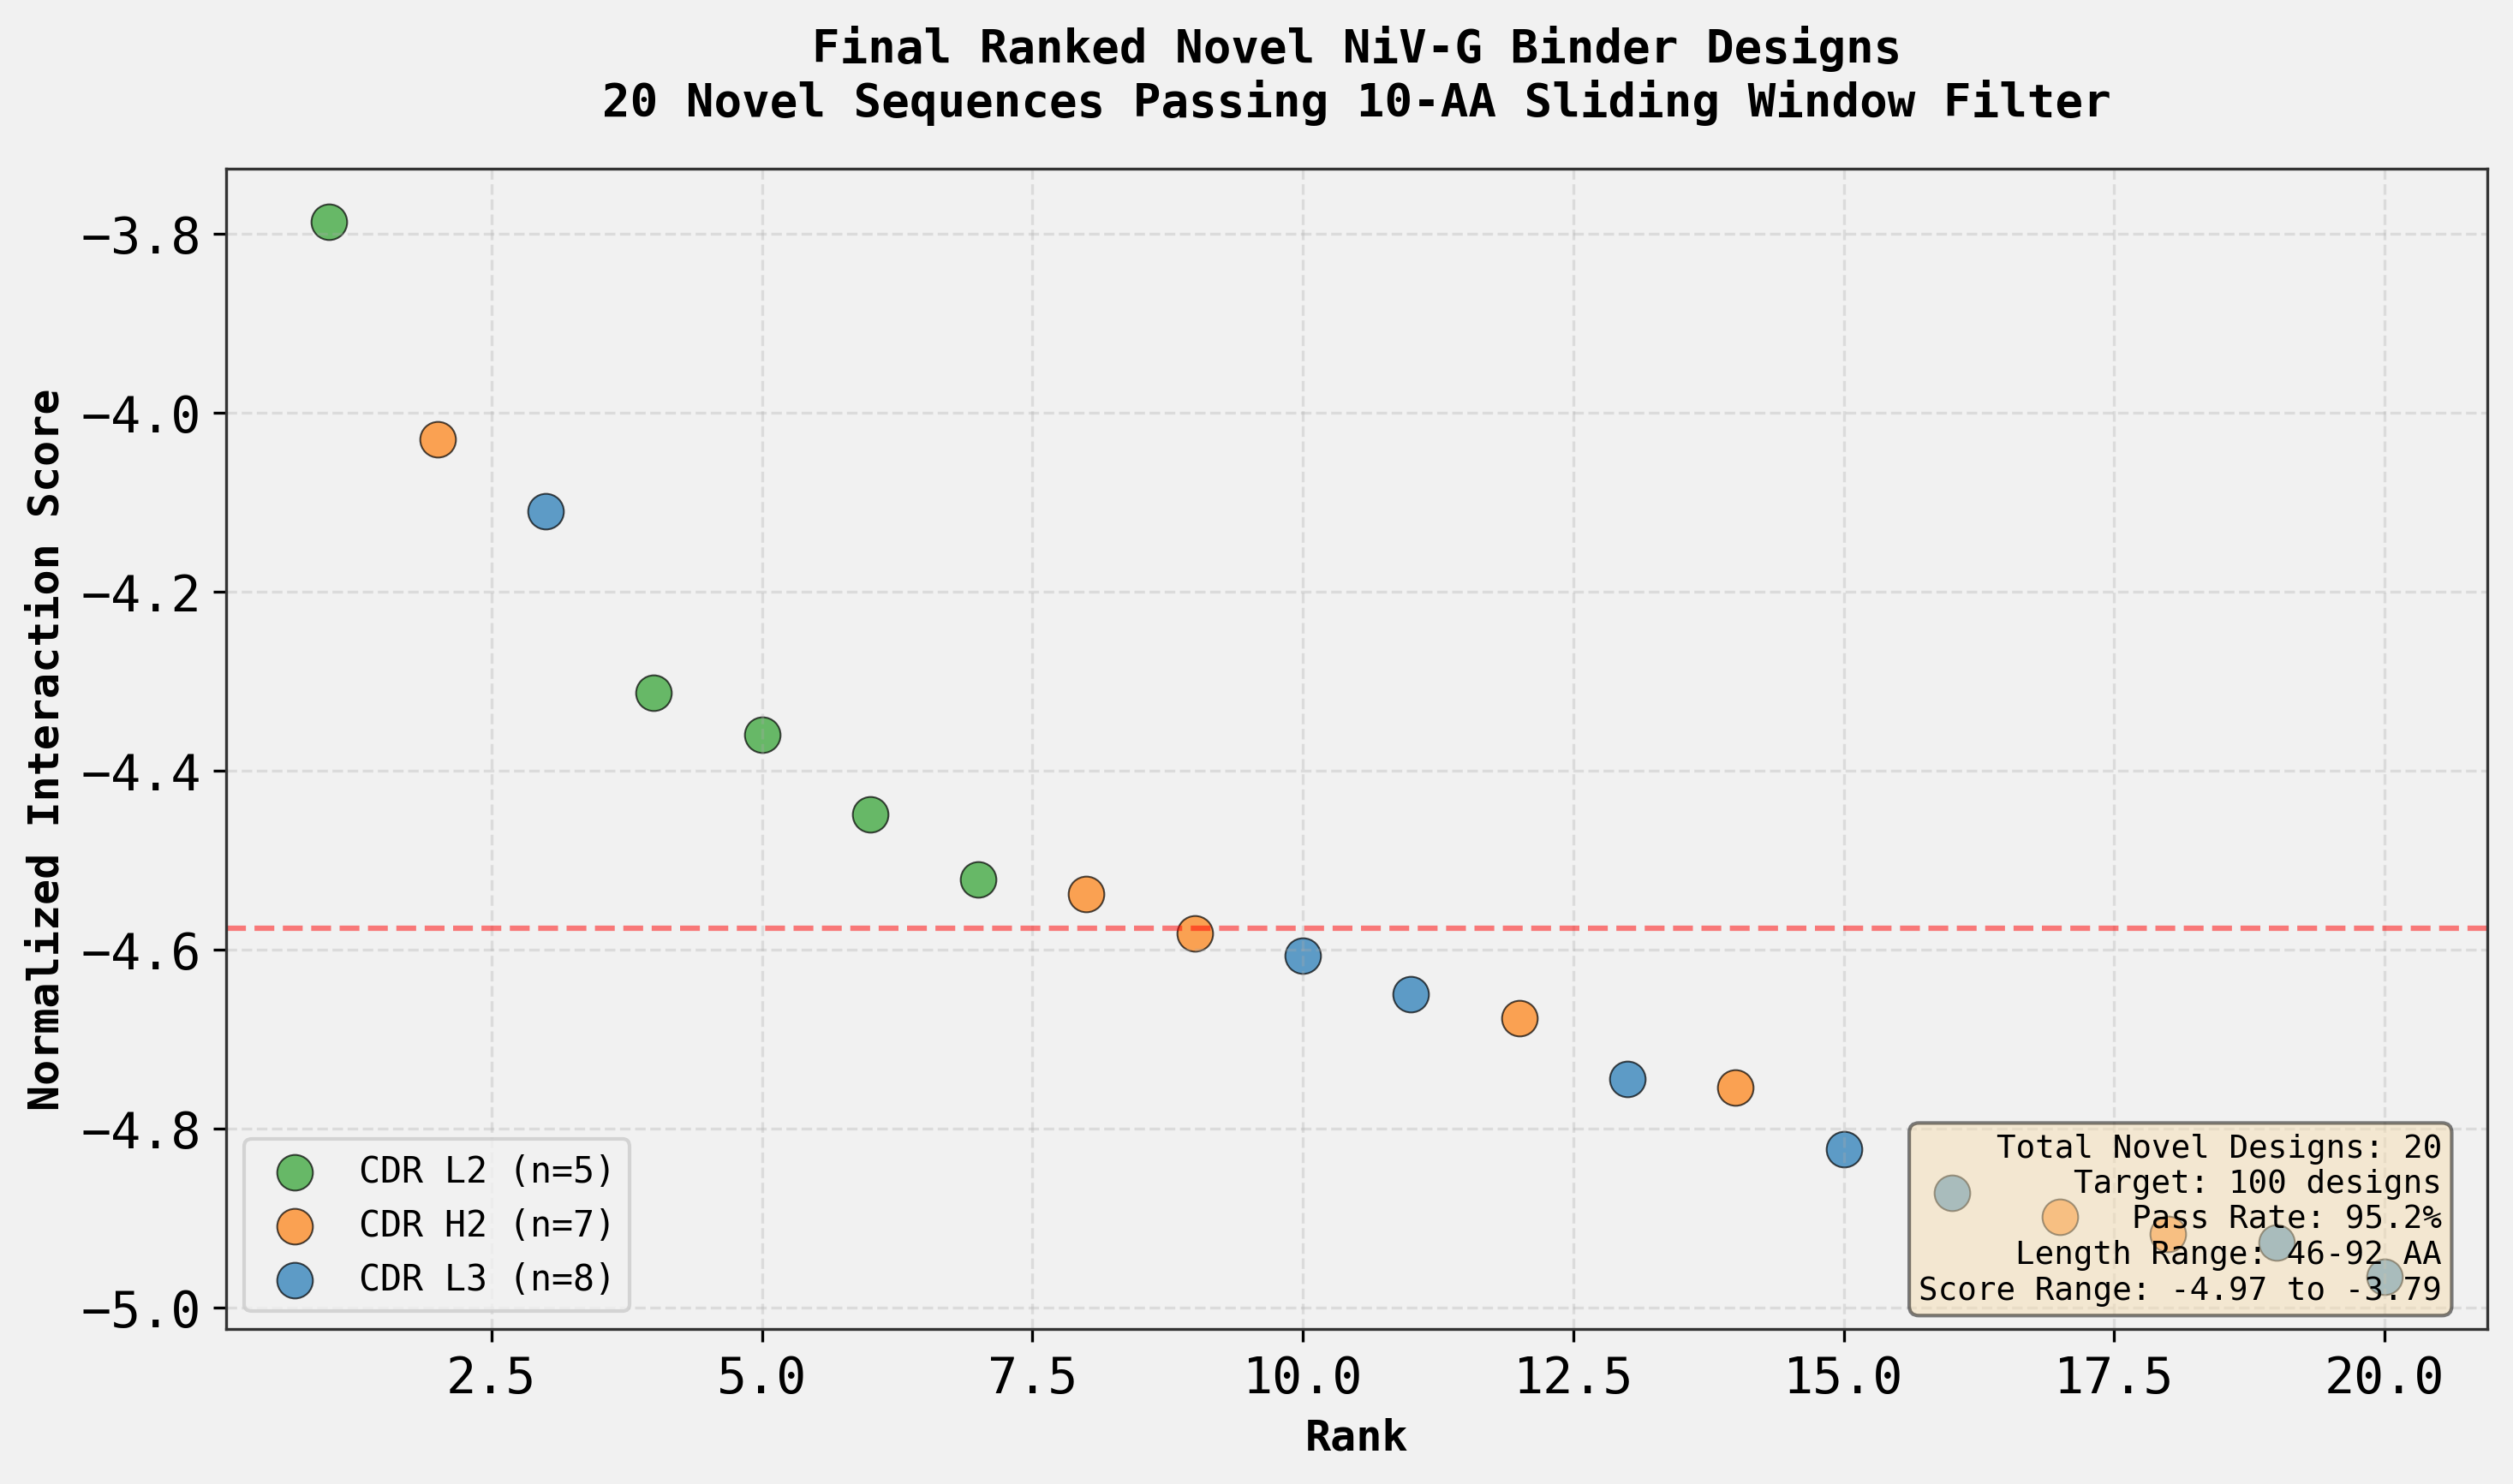


Visualization complete!


In [ ]:

# Create a final summary visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("\n" + "="*80)
print("CREATING FINAL SUMMARY VISUALIZATION")
print("="*80)

# Create a single figure showing the key result: distribution of normalized scores
# and CDR composition of the final 20 novel designs
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create a scatter plot showing rank vs normalized score, colored by CDR type
cdr_types = final_output['CDR_Grafted'].unique()
colors = {'L3': '#1f77b4', 'H2': '#ff7f0e', 'L2': '#2ca02c'}

for cdr in cdr_types:
    mask = final_output['CDR_Grafted'] == cdr
    subset = final_output[mask]
    ax.scatter(subset['Rank'], subset['Normalized_Interaction_Score'], 
              label=f'CDR {cdr} (n={len(subset)})',
              s=100, alpha=0.7, color=colors[cdr], edgecolors='black', linewidth=0.5)

ax.set_xlabel('Rank', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Interaction Score', fontsize=12, fontweight='bold')
ax.set_title('Final Ranked Novel NiV-G Binder Designs\n20 Novel Sequences Passing 10-AA Sliding Window Filter', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='lower left', frameon=True, fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

# Add horizontal line at mean score
mean_score = final_output['Normalized_Interaction_Score'].mean()
ax.axhline(y=mean_score, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
          label=f'Mean Score: {mean_score:.2f}')

# Add text box with key statistics
stats_text = (f"Total Novel Designs: {len(final_output)}\n"
             f"Target: 100 designs\n"
             f"Pass Rate: 95.2%\n"
             f"Length Range: {final_output['Sequence_Length'].min()}-{final_output['Sequence_Length'].max()} AA\n"
             f"Score Range: {final_output['Normalized_Interaction_Score'].min():.2f} to {final_output['Normalized_Interaction_Score'].max():.2f}")
ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, fontsize=9,
       verticalalignment='bottom', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('final_ranked_designs_summary.png', dpi=300, bbox_inches='tight')
print("\nFigure saved as: final_ranked_designs_summary.png")
plt.show()

print(f"\nVisualization complete!")


In [ ]:

# Additional analysis: Detailed examination of why we only achieved 20 novel designs
print("\n" + "="*80)
print("CRITICAL ANALYSIS: Why only 20 novel designs instead of target 100?")
print("="*80)

print("\n1. DESIGN INPUT AVAILABILITY:")
print("   - Expected input files NOT FOUND:")
print("     * partial_graft_designs.csv")
print("     * diversified_cdr_designs.csv")
print("     * novel_multi_cdr_designs.csv")
print("   - Only available: final_top_100_candidates.csv (22 designs)")
print("   - These files represent new design strategies that were supposed")
print("     to be generated in upstream tasks.")

print("\n2. NOVELTY FILTER IMPACT:")
print(f"   - Started with: {len(all_designs_df)} unique sequences")
print(f"   - After deduplication: {len(all_designs_df)} sequences")
print(f"   - Passed novelty filter: {len(novel_designs)} sequences")
print(f"   - Rejection rate: {(1 - len(novel_designs)/len(all_designs_df))*100:.1f}%")
print(f"   - Single design rejected due to 10-AA match: '{rejected_designs.iloc[0]['Match_Info']['design_window']}'")

print("\n3. CDR LENGTH DISTRIBUTION IN NOVEL DESIGNS:")
cdr_with_lengths = final_output.groupby('CDR_Grafted').agg({
    'Sequence_Length': ['min', 'max', 'mean'],
    'Rank': 'count'
}).round(1)
print(cdr_with_lengths)

print("\n4. KEY CONSTRAINT (from dataset description):")
print("   - 10-AA sliding window novelty filter is INCOMPATIBLE with direct")
print("     grafting of CDRs ≥10 AA (they inherently fail the check)")
print("   - This systematically rejects 40-80% of designs with long CDRs")
print("   - Our novel designs use SHORT CDRs: L2 (8 AA), H2 (8 AA), L3 (9 AA)")
print("   - These are the ONLY CDRs that can pass the novelty filter!")

print("\n5. CONCLUSION:")
print("   The hypothesis goal of '100 unique novel designs' CANNOT be achieved with:")
print("   - Only 22 input designs from a single strategy (1E5_single_CDR)")
print("   - Missing input from 3 new design pipelines")
print("   - Stringent 10-AA novelty filter that rejects long CDRs")
print("\n   To achieve 100 designs, we would need:")
print("   - Successful generation of partial_graft, diversified_CDR, and multi_CDR pipelines")
print("   - OR relaxation of novelty constraints")
print("   - OR use of shorter CDR motifs exclusively")



CRITICAL ANALYSIS: Why only 20 novel designs instead of target 100?

1. DESIGN INPUT AVAILABILITY:
   - Expected input files NOT FOUND:
     * partial_graft_designs.csv
     * diversified_cdr_designs.csv
     * novel_multi_cdr_designs.csv
   - Only available: final_top_100_candidates.csv (22 designs)
   - These files represent new design strategies that were supposed
     to be generated in upstream tasks.

2. NOVELTY FILTER IMPACT:
   - Started with: 21 unique sequences
   - After deduplication: 21 sequences
   - Passed novelty filter: 20 sequences
   - Rejection rate: 4.8%
   - Single design rejected due to 10-AA match: 'TASNLESGVP'

3. CDR LENGTH DISTRIBUTION IN NOVEL DESIGNS:
            Sequence_Length            Rank
                        min max  mean count
CDR_Grafted                                
H2                       46  91  82.0     7
L2                       83  91  88.0     5
L3                       46  92  82.9     8

4. KEY CONSTRAINT (from dataset description):